# 预训练word2vec
:label:`sec_word2vec_pretraining`

我们继续实现 :numref:`sec_word2vec`中定义的跳元语法模型。然后，我们将在PTB数据集上使用负采样预训练word2vec。首先，让我们通过调用`d2l.load_data_ptb`函数来获得该数据集的数据迭代器和词表，该函数在 :numref:`sec_word2vec_data`中进行了描述。


In [1]:
import sys
sys.path.append('..')

In [2]:
import math
import mindspore
import mindspore.nn as nn
import mindspore.ops as ops
from d2l import mindspore as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
dataset, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

## 跳元模型

我们通过嵌入层和批量矩阵乘法实现了跳元模型。首先，让我们回顾一下嵌入层是如何工作的。

### 嵌入层

如 :numref:`sec_seq2seq`中所述，嵌入层将词元的索引映射到其特征向量。该层的权重是一个矩阵，其行数等于字典大小（`input_dim`），列数等于每个标记的向量维数（`output_dim`）。在词嵌入模型训练之后，这个权重就是我们所需要的。


In [3]:
embed = nn.Embedding(vocab_size=20, embedding_size=4)
print(f'Parameter embedding_weight ({embed.embedding_table.shape}, '
      f'dtype={embed.embedding_table.dtype})')

Parameter embedding_weight ((20, 4), dtype=Float32)


嵌入层的输入是词元（词）的索引。对于任何词元索引$i$，其向量表示可以从嵌入层中的权重矩阵的第$i$行获得。由于向量维度（`output_dim`）被设置为4，因此当小批量词元索引的形状为（2，3）时，嵌入层返回具有形状（2，3，4）的向量。


In [4]:
x = mindspore.Tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

Tensor(shape=[2, 3, 4], dtype=Float32, value=
[[[-4.44511386e-07,  6.75162021e-03, -1.10750450e-02, -4.48313728e-03],
  [-3.80617043e-04, -3.46304267e-04, -1.00970650e-02,  8.21283739e-03],
  [-1.19789327e-02, -1.37363840e-02, -5.93600213e-04, -1.00296247e-03]],
 [[ 4.71872091e-03, -4.49423585e-03, -3.06172739e-03, -2.19914801e-02],
  [ 2.38259858e-03,  1.24084332e-03, -8.02362617e-03, -2.24583466e-02],
  [ 5.16804680e-03,  1.11878654e-02,  1.04257055e-02, -1.67296249e-02]]])

### 定义前向传播

在前向传播中，跳元语法模型的输入包括形状为（批量大小，1）的中心词索引`center`和形状为（批量大小，`max_len`）的上下文与噪声词索引`contexts_and_negatives`，其中`max_len`在 :numref:`subsec_word2vec-minibatch-loading`中定义。这两个变量首先通过嵌入层从词元索引转换成向量，然后它们的批量矩阵相乘（在 :numref:`subsec_batch_dot`中描述）返回形状为（批量大小，1，`max_len`）的输出。输出中的每个元素是中心词向量和上下文或噪声词向量的点积。


In [5]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = ops.bmm(v, u.permute(0, 2, 1))
    return pred

让我们为一些样例输入打印此`skip_gram`函数的输出形状。


In [6]:
skip_gram(ops.ones((2, 1), mindspore.int64),
          ops.ones((2, 4), mindspore.int64), embed, embed).shape

(2, 1, 4)

## 训练

在训练带负采样的跳元模型之前，我们先定义它的损失函数。

### 二元交叉熵损失

根据 :numref:`subsec_negative-sampling`中负采样损失函数的定义，我们将使用二元交叉熵损失。


In [7]:
class SigmoidBCELoss(nn.Cell):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()

    def construct(self, inputs, target, mask=None):
        out = ops.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, pos_weight=mask, reduction="none") # pos_weight的取值
        return out.mean(axis=1)

loss = SigmoidBCELoss()

回想一下我们在 :numref:`subsec_word2vec-minibatch-loading`中对掩码变量和标签变量的描述。下面计算给定变量的二进制交叉熵损失。


In [8]:
pred = mindspore.Tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = mindspore.Tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = mindspore.Tensor([[1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.0, 0.0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

Tensor(shape=[2], dtype=Float32, value= [ 9.35210109e-01,  1.84620929e+00])

下面显示了如何使用二元交叉熵损失中的Sigmoid激活函数（以较低效率的方式）计算上述结果。我们可以将这两个输出视为两个规范化的损失，在非掩码预测上进行平均。


In [9]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


### 初始化模型参数

我们定义了两个嵌入层，将词表中的所有单词分别作为中心词和上下文词使用。字向量维度`embed_size`被设置为100。


In [10]:
embed_size = 100
net = nn.SequentialCell(nn.Embedding(vocab_size=len(vocab),
                                     embedding_size=embed_size),
                        nn.Embedding(vocab_size=len(vocab),
                                     embedding_size=embed_size))

### 定义训练阶段代码

训练阶段代码实现定义如下。由于填充的存在，损失函数的计算与以前的训练函数略有不同。


In [11]:
from mindspore.common.initializer import initializer

def train(net, dataset, lr, num_epochs):
    def init_weights(m):
        if type(m) == nn.Embedding:
            m.embedding_table.set_data(initializer('xavier_uniform', m.embedding_table.shape, m.embedding_table.dtype))
    net.apply(init_weights)
    optimizer = nn.Adam(params=net.trainable_params(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # 规范化的损失之和，规范化的损失数
    metric = d2l.Accumulator(2)
    def forward_fn(batch):
        center, context_negative, mask, label = batch
        pred = skip_gram(center, context_negative, net[0], net[1])
        l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                 / mask.sum(axis=1) * mask.shape[1])
        return l, l.sum()
    grad_fn = mindspore.value_and_grad(forward_fn, None, weights=net.trainable_params(), has_aux=True)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), dataset.get_dataset_size()
        net.set_train()
        for i, batch in enumerate(dataset.create_tuple_iterator()):
            (l, l_sum), grads = grad_fn(batch)
            optimizer(grads)
            metric.add(l_sum, l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec')

现在，我们可以使用负采样来训练跳元模型。


RuntimeError: The pointer[mgr] is null.

----------------------------------------------------
- C++ Call Stack: (For framework developers)
----------------------------------------------------
mindspore/ccsrc/backend/graph_compiler/segment_runner.cc:146 TransformSegmentToAnfGraph


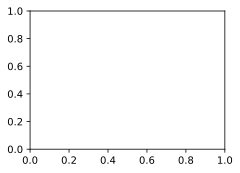

In [12]:
lr, num_epochs = 0.002, 5
train(net, dataset, lr, num_epochs)

## 应用词嵌入
:label:`subsec_apply-word-embed`

在训练word2vec模型之后，我们可以使用训练好模型中词向量的余弦相似度来从词表中找到与输入单词语义最相似的单词。


In [ ]:
def get_similar_tokens(query_token, k, embed):
    W = embed.embedding_table.data
    x = W[vocab[query_token]]
    # 计算余弦相似性。增加1e-9以获得数值稳定性
    cos = ops.mv(W, x) / ops.sqrt(ops.sum(W * W, dim=1) *
                                  ops.sum(x * x) + 1e-9)
    topk = ops.topk(cos, k=k+1)[1].astype('int32')
    for i in topk[1:]:  # 删除输入词
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

## 小结

* 我们可以使用嵌入层和二元交叉熵损失来训练带负采样的跳元模型。
* 词嵌入的应用包括基于词向量的余弦相似度为给定词找到语义相似的词。

## 练习

1. 使用训练好的模型，找出其他输入词在语义上相似的词。您能通过调优超参数来改进结果吗？
1. 当训练语料库很大时，在更新模型参数时，我们经常对当前小批量的*中心词*进行上下文词和噪声词的采样。换言之，同一中心词在不同的训练迭代轮数可以有不同的上下文词或噪声词。这种方法的好处是什么？尝试实现这种训练方法。
